# UCF101 Skeleton-Based Action Recognition

This notebook demonstrates the full pipeline for training and evaluating skeleton-based action recognition models on the UCF101 dataset. We'll cover:

1. Loading and exploring the UCF101 skeleton dataset
2. Training the baseline MLP model
3. Training the CNN+LSTM model
4. Evaluating model performance
5. Making predictions on sample data


## 1. Setup and Imports


In [22]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import yaml
from tqdm.notebook import tqdm

# Add the project root to the path so we can import from src
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

# Import project modules
from src.datasets.skeleton_dataset import SkeletonDataset
from src.models.baseline_mlp import create_baseline_model
from src.models.cnn_lstm import create_cnn_lstm_model
from src.utils.seed import set_seed
from src.utils.metrics import compute_metrics, compute_confusion_matrix
from src.utils.plotting import plot_training_curves, plot_confusion_matrix
from src.utils.ucf101_classes import get_class_name, UCF101_CLASSES

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load Configuration


In [23]:
with open('../configs/baseline.yaml', 'r') as f:
    baseline_config = yaml.safe_load(f)

with open('../configs/cnn_lstm.yaml', 'r') as f:
    cnn_lstm_config = yaml.safe_load(f)

set_seed(baseline_config['seed'])

print("Baseline Config:")
print(yaml.dump(baseline_config, default_flow_style=False))
print("\nCNN+LSTM Config:")
print(yaml.dump(cnn_lstm_config, default_flow_style=False))

Baseline Config:
dataset:
  class_names: null
  data_path: ../data/ucf101_2d.pkl
  num_coords: 2
  num_frames: 64
  num_joints: 17
model:
  dropout: 0.5
  hidden_sizes:
  - 1024
  - 512
  - 256
  input_size: 2176
  name: BaselineMLP
  num_classes: 101
paths:
  log_dir: results/baseline/logs
  save_dir: results/baseline
seed: 42
training:
  batch_size: 32
  early_stopping_patience: 10
  learning_rate: 0.001
  num_epochs: 100
  scheduler_factor: 0.1
  scheduler_min_lr: 1.0e-05
  scheduler_patience: 5
  weight_decay: 0.0001


CNN+LSTM Config:
dataset:
  class_names: null
  data_path: ../data/ucf101_2d.pkl
  num_coords: 2
  num_frames: 64
  num_joints: 17
model:
  bidirectional: true
  conv_channels:
  - 32
  - 64
  - 128
  conv_kernel_sizes:
  - 3
  - 3
  - 3
  fc_dropout: 0.5
  fc_sizes:
  - 512
  - 256
  input_channels: 2
  input_frames: 64
  input_joints: 17
  lstm_dropout: 0.2
  lstm_hidden_size: 256
  lstm_num_layers: 2
  name: CNNLSTMModel
  num_classes: 101
paths:
  log_dir: result

## 3. Explore the UCF101 Skeleton Dataset


In [24]:
data_path = './../data/ucf101_2d.pkl'

with open(data_path, 'rb') as f:
    data = pickle.load(f)

print("Dataset keys:", data.keys())
print("\nSplit information:")
for split_name, split_ids in data['split'].items():
    print(f"  {split_name}: {len(split_ids)} samples")

print(f"\nTotal annotations: {len(data['annotations'])}")

sample_annotation = data['annotations'][0]

print("\nSample annotation keys:", sample_annotation.keys())
print(f"  Video ID (frame_dir): {sample_annotation['frame_dir']}")
print(f"  Frame count (total_frames): {sample_annotation['total_frames']}")
print(f"  Image shape: {sample_annotation['img_shape']}")
print(f"  Label index: {sample_annotation['label']}")
print(f"  Label class: {get_class_name(sample_annotation['label'])}")
print(f"  Keypoint shape: {sample_annotation['keypoint'].shape}")

Dataset keys: dict_keys(['split', 'annotations'])

Split information:
  train1: 9537 samples
  train2: 9586 samples
  train3: 9624 samples
  test1: 3783 samples
  test2: 3734 samples
  test3: 3696 samples

Total annotations: 13320

Sample annotation keys: dict_keys(['keypoint', 'keypoint_score', 'frame_dir', 'total_frames', 'original_shape', 'img_shape', 'label'])
  Video ID (frame_dir): v_ApplyEyeMakeup_g08_c01
  Frame count (total_frames): 119
  Image shape: (256, 340)
  Label index: 0
  Label class: ApplyEyeMakeup
  Keypoint shape: (1, 119, 17, 2)


### Visualize a Skeleton Sequence


Sample ID: v_ApplyEyeMakeup_g08_c01
Action: ApplyEyeMakeup
Number of frames: 119
Number of persons: 1


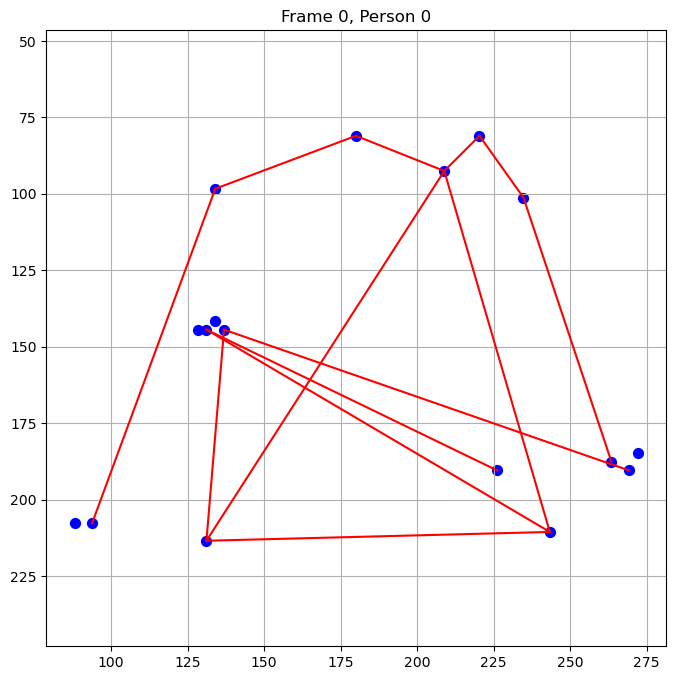

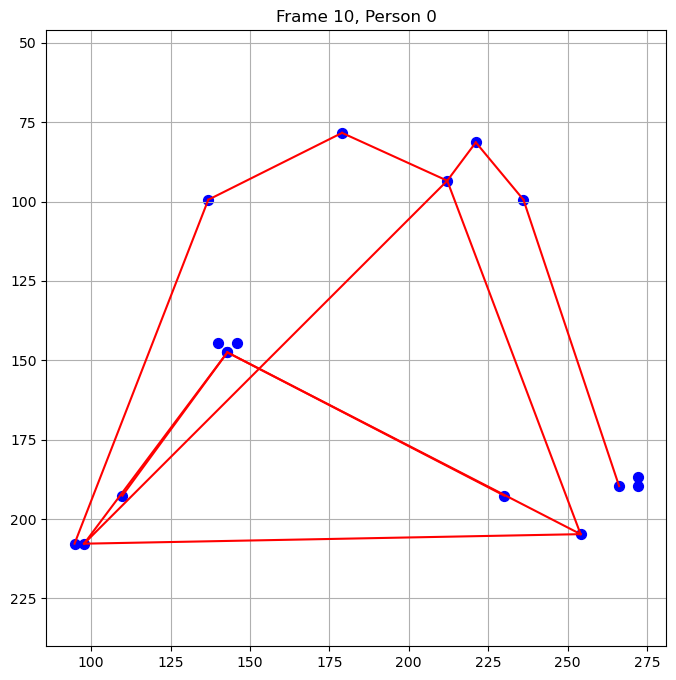

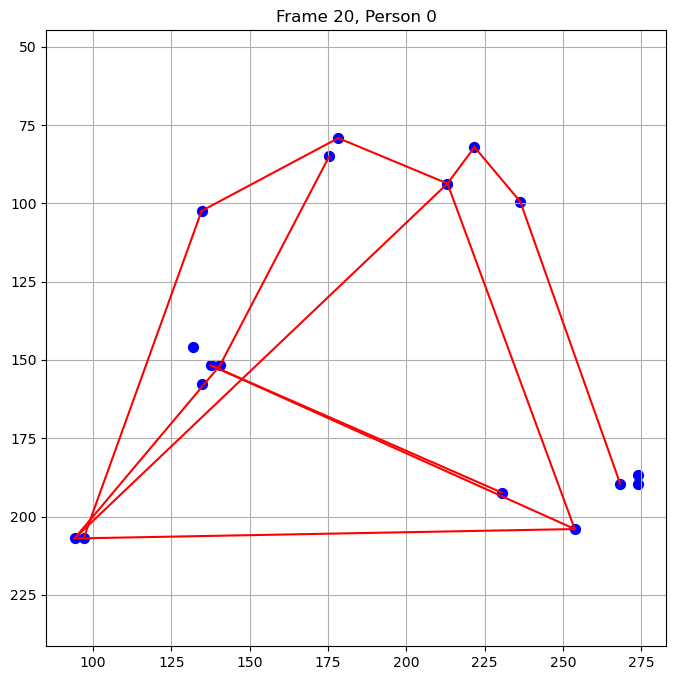

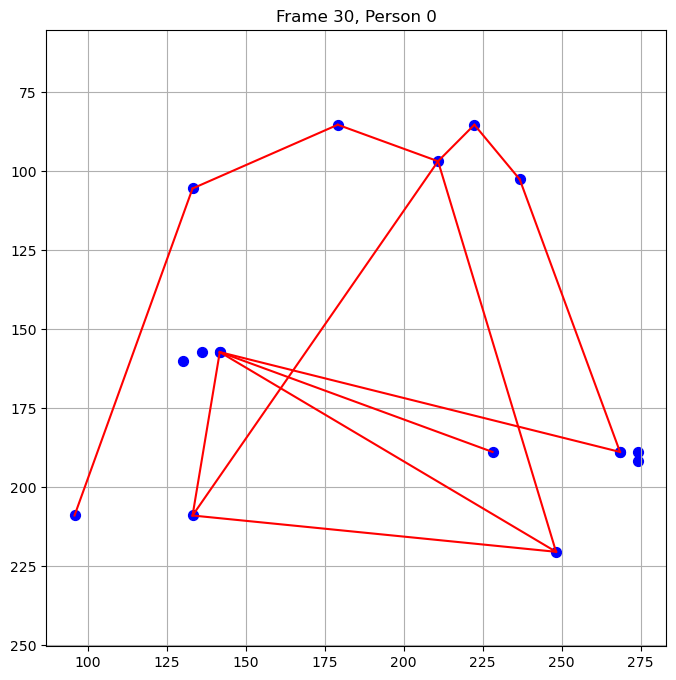

In [25]:
def plot_skeleton(keypoints, frame_idx=0, person_idx=0):

    # COCO keypoint connections
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4),
        (3, 5), (4, 6),
        (0, 7), (7, 9), (9, 11),
        (0, 8), (8, 10), (10, 12),
        (7, 8)
    ]

    kp = keypoints[person_idx, frame_idx, :, :2]

    plt.figure(figsize=(8, 8))
    plt.scatter(kp[:, 0], kp[:, 1], c='blue', s=50)

    for connection in connections:
        plt.plot(kp[connection, 0], kp[connection, 1], 'r-')

    plt.gca().invert_yaxis()
    plt.title(f"Frame {frame_idx}, Person {person_idx}")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

sample_idx = 0
sample = data['annotations'][sample_idx]
print(f"Sample ID: {sample['frame_dir']}")
print(f"Action: {get_class_name(sample['label'])}")
print(f"Number of frames: {sample['total_frames']}")
print(f"Number of persons: {sample['keypoint'].shape[0]}")

for frame_idx in [0, 10, 20, 30]:
    if frame_idx < sample['keypoint'].shape[1]:
        plot_skeleton(sample['keypoint'], frame_idx=frame_idx, person_idx=0)

## 4. Create Data Loaders


In [26]:
full_train_dataset = SkeletonDataset(
    data_path=baseline_config['dataset']['data_path'],
    split='train1',
    num_frames=baseline_config['dataset']['num_frames'],
    num_joints=baseline_config['dataset']['num_joints'],
    num_coords=baseline_config['dataset']['num_coords'],
    class_names=baseline_config['dataset']['class_names']
)

test_dataset = SkeletonDataset(
    data_path=baseline_config['dataset']['data_path'],
    split='test1',
    num_frames=baseline_config['dataset']['num_frames'],
    num_joints=baseline_config['dataset']['num_joints'],
    num_coords=baseline_config['dataset']['num_coords'],
    class_names=baseline_config['dataset']['class_names']
)

val_ratio = 0.1
val_size = int(len(full_train_dataset) * val_ratio)
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 8584
Validation dataset size: 953
Test dataset size: 3783


### Examine a Batch of Data


In [27]:
for skeletons, labels in train_dataloader:
    break

print(f"Skeleton batch shape: {skeletons.shape}")
print(f"Labels shape: {labels.shape}")

for i in range(min(5, len(labels))):
    print(f"Sample {i}: Label {labels[i].item()} ({get_class_name(labels[i].item())})")

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Skeleton batch shape: torch.Size([32, 64, 34])
Labels shape: torch.Size([32])
Sample 0: Label 36 (HandstandPushups)
Sample 1: Label 18 (BreastStroke)
Sample 2: Label 43 (IceDancing)
Sample 3: Label 64 (PlayingSitar)
Sample 4: Label 100 (YoYo)


## 5. Training Functions


In [28]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    all_preds = []
    all_labels = []

    for skeletons, labels in tqdm(dataloader, desc="Training", leave=False):
        skeletons = skeletons.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(skeletons)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and predictions
        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)

    return epoch_loss / len(dataloader), metrics['accuracy']


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for skeletons, labels in tqdm(dataloader, desc="Validating", leave=False):
            skeletons = skeletons.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(skeletons)
            loss = criterion(outputs, labels)

            # Track loss and predictions
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)

    return val_loss / len(dataloader), metrics['accuracy'], metrics

## 6. Train Baseline MLP Model

For demonstration purposes, we'll train for fewer epochs than specified in the config.


Training baseline MLP model...


Training:   0%|          | 0/269 [00:00<?, ?it/s]

Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 - Train Loss: 4.5696, Train Acc: 0.0193, Val Loss: 4.3188, Val Acc: 0.0220
Saved best model with validation accuracy: 0.0220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 - Train Loss: 4.2958, Train Acc: 0.0330, Val Loss: 4.0162, Val Acc: 0.0441
Saved best model with validation accuracy: 0.0441


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 - Train Loss: 4.0837, Train Acc: 0.0445, Val Loss: 3.8743, Val Acc: 0.0535
Saved best model with validation accuracy: 0.0535


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 - Train Loss: 3.9867, Train Acc: 0.0506, Val Loss: 3.7792, Val Acc: 0.0913
Saved best model with validation accuracy: 0.0913


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 - Train Loss: 3.9037, Train Acc: 0.0577, Val Loss: 3.7494, Val Acc: 0.0818


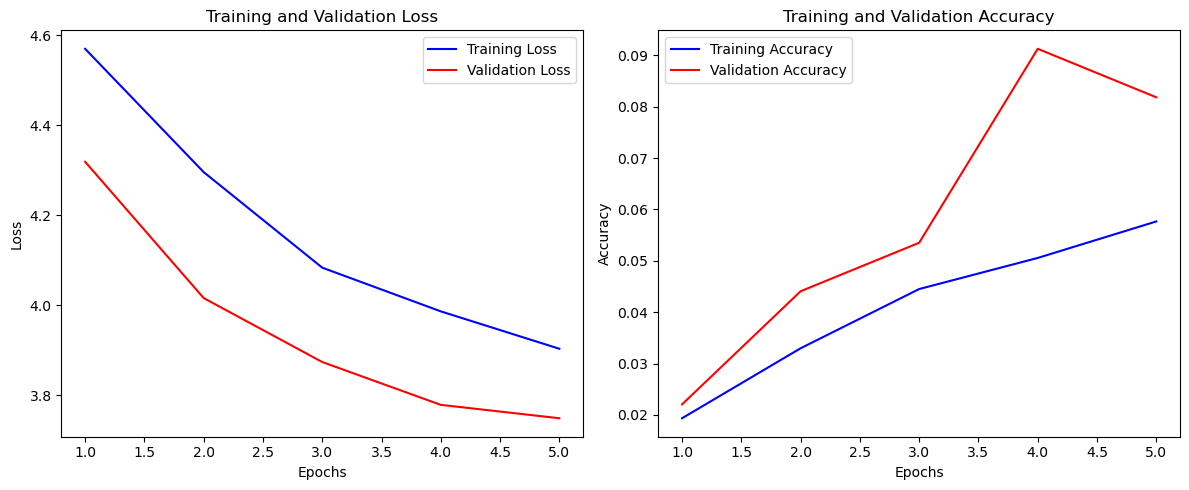

In [29]:
baseline_model = create_baseline_model(baseline_config['model'])
baseline_model = baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    baseline_model.parameters(),
    lr=baseline_config['training']['learning_rate'],
    weight_decay=baseline_config['training']['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=baseline_config['training']['scheduler_factor'],
    patience=baseline_config['training']['scheduler_patience'],
    min_lr=baseline_config['training']['scheduler_min_lr'],
)

num_epochs = 5
best_val_accuracy = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Training baseline MLP model...")
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(baseline_model, train_dataloader, criterion, optimizer, device)

    val_loss, val_accuracy, val_metrics = validate(baseline_model, val_dataloader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': baseline_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'val_metrics': val_metrics
        }, '../results/baseline/best_model.pth')
        print(f"Saved best model with validation accuracy: {val_accuracy:.4f}")

plot_training_curves(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies
)

## 7. Train CNN+LSTM Model

For demonstration purposes, we'll train for fewer epochs than specified in the config.


Training CNN+LSTM model...


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 - Train Loss: 4.2294, Train Acc: 0.0388, Val Loss: 3.6837, Val Acc: 0.0735
Saved best model with validation accuracy: 0.0735


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/5 - Train Loss: 3.6954, Train Acc: 0.0796, Val Loss: 3.4265, Val Acc: 0.1081
Saved best model with validation accuracy: 0.1081


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/5 - Train Loss: 3.4583, Train Acc: 0.1118, Val Loss: 3.1710, Val Acc: 0.1532
Saved best model with validation accuracy: 0.1532


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/5 - Train Loss: 3.2666, Train Acc: 0.1401, Val Loss: 3.0081, Val Acc: 0.2004
Saved best model with validation accuracy: 0.2004


Training:   0%|          | 0/269 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validating:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/5 - Train Loss: 3.0971, Train Acc: 0.1751, Val Loss: 2.8186, Val Acc: 0.2434
Saved best model with validation accuracy: 0.2434


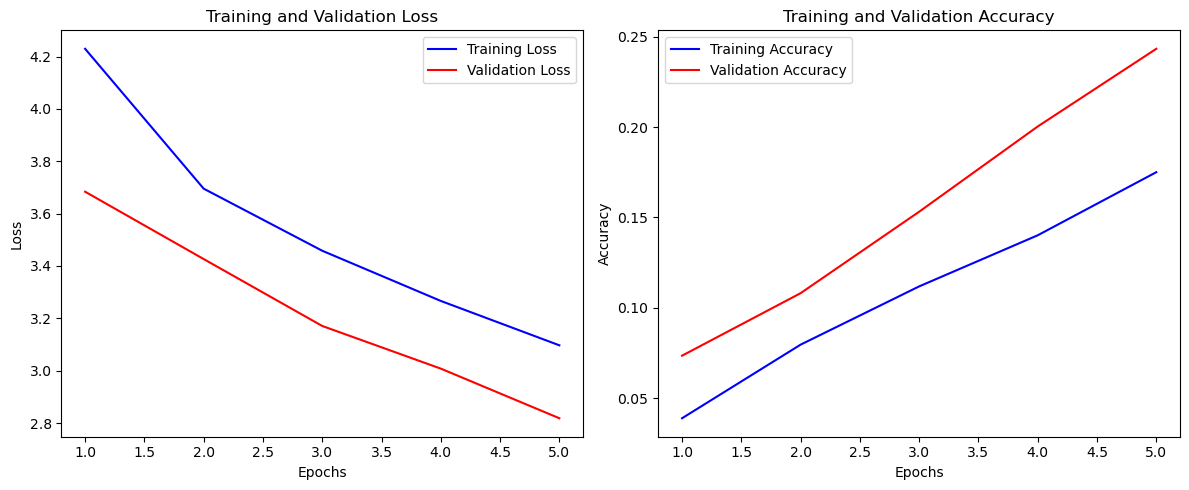

In [30]:
cnn_lstm_model = create_cnn_lstm_model(cnn_lstm_config['model'])
cnn_lstm_model = cnn_lstm_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    cnn_lstm_model.parameters(),
    lr=cnn_lstm_config['training']['learning_rate'],
    weight_decay=cnn_lstm_config['training']['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=cnn_lstm_config['training']['scheduler_factor'],
    patience=cnn_lstm_config['training']['scheduler_patience'],
    min_lr=cnn_lstm_config['training']['scheduler_min_lr'],
)

num_epochs = 5  # Reduced for demonstration
best_val_accuracy = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Training CNN+LSTM model...")
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(cnn_lstm_model, train_dataloader, criterion, optimizer, device)

    val_loss, val_accuracy, val_metrics = validate(cnn_lstm_model, val_dataloader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': cnn_lstm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'val_metrics': val_metrics
        }, '../results/cnn_lstm/best_model.pth')
        print(f"Saved best model with validation accuracy: {val_accuracy:.4f}")

plot_training_curves(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies
)

## 8. Evaluate Models on Test Set


In [31]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for skeletons, labels in tqdm(dataloader, desc="Evaluating"):
            skeletons = skeletons.to(device)

            # Forward pass
            outputs = model(skeletons)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    metrics = compute_metrics(all_labels, all_preds)
    cm = compute_confusion_matrix(all_labels, all_preds)

    return metrics, cm, np.array(all_preds), np.array(all_labels)

### Evaluate Baseline MLP Model


Loaded baseline model from epoch 3 with validation accuracy 0.0913


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Baseline MLP Test Results:
Accuracy: 0.0708
Precision: 0.0270
Recall: 0.0691
F1 Score: 0.0301


/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_56852/2481106640.py:38: RuntimeWarning: invalid value encountered in divide
  top_cm_norm = top_cm / row_sums


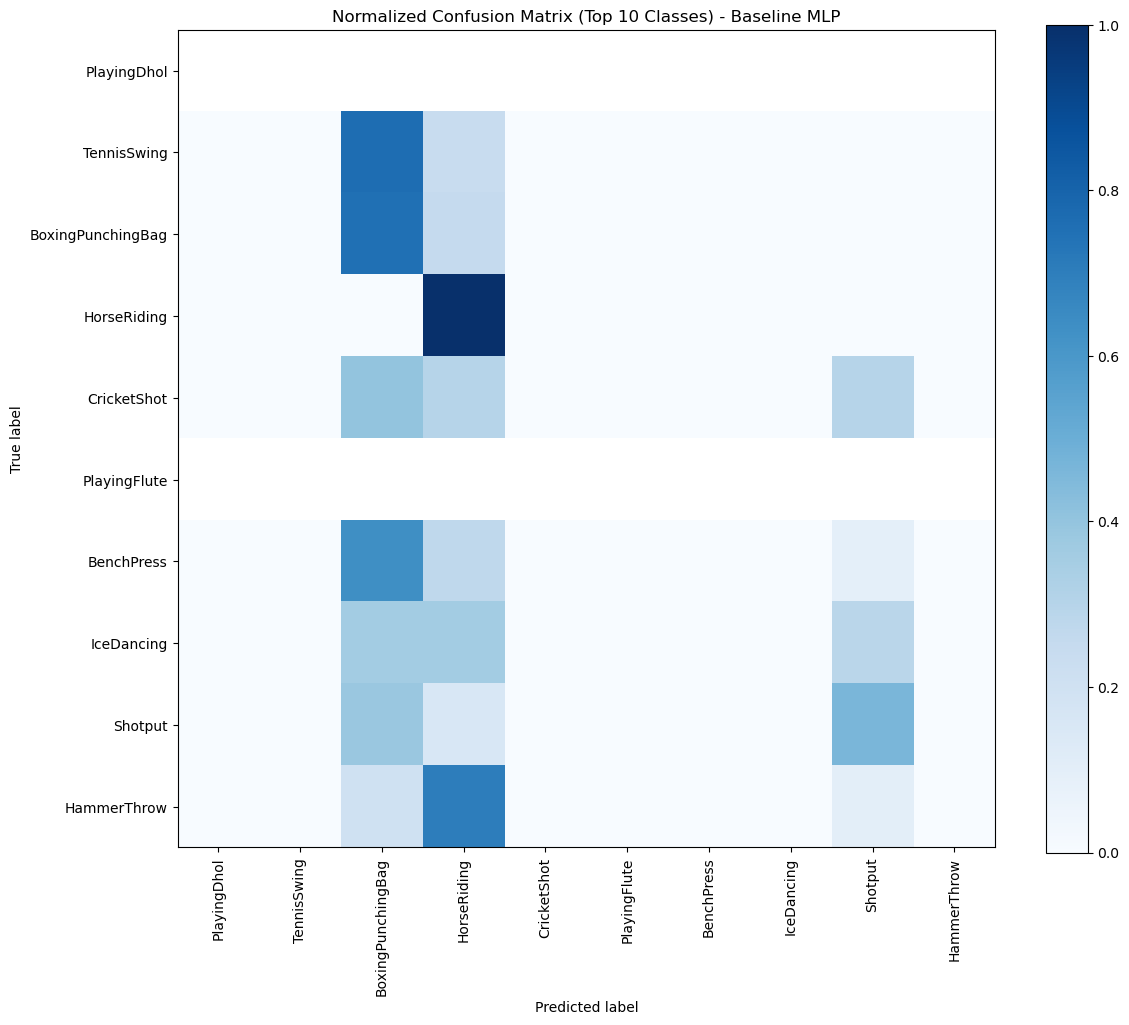

In [32]:
try:
    checkpoint = torch.load('../results/baseline/best_model.pth', map_location=device)
    baseline_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded baseline model from epoch {checkpoint['epoch']} with validation accuracy {checkpoint['val_accuracy']:.4f}")
except FileNotFoundError:
    print("No saved baseline model found. Using the last trained model.")

baseline_metrics, baseline_cm, baseline_preds, baseline_labels = evaluate_model(baseline_model, test_dataloader, device)

print("\nBaseline MLP Test Results:")
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall: {baseline_metrics['recall']:.4f}")
print(f"F1 Score: {baseline_metrics['f1']:.4f}")

unique_classes = np.unique(np.concatenate([baseline_labels, baseline_preds]))
class_names = [UCF101_CLASSES[i] for i in unique_classes]

class_counts = np.bincount(baseline_labels)
top_classes = np.argsort(class_counts)[-10:][::-1]
top_class_names = [UCF101_CLASSES[i] for i in top_classes]

top_cm = np.zeros((len(top_classes), len(top_classes)))
for i, true_class in enumerate(top_classes):
    for j, pred_class in enumerate(top_classes):
        mask = (baseline_labels == true_class) & (baseline_preds == pred_class)
        top_cm[i, j] = np.sum(mask)

row_sums = top_cm.sum(axis=1, keepdims=True)
top_cm_norm = top_cm / row_sums

plt.figure(figsize=(12, 10))
plt.imshow(top_cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Top 10 Classes) - Baseline MLP')
plt.colorbar()
tick_marks = np.arange(len(top_class_names))
plt.xticks(tick_marks, top_class_names, rotation=90)
plt.yticks(tick_marks, top_class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Evaluate CNN+LSTM Model


Loaded CNN+LSTM model from epoch 4 with validation accuracy 0.2434


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



CNN+LSTM Test Results:
Accuracy: 0.2088
Precision: 0.1868
Recall: 0.2040
F1 Score: 0.1607


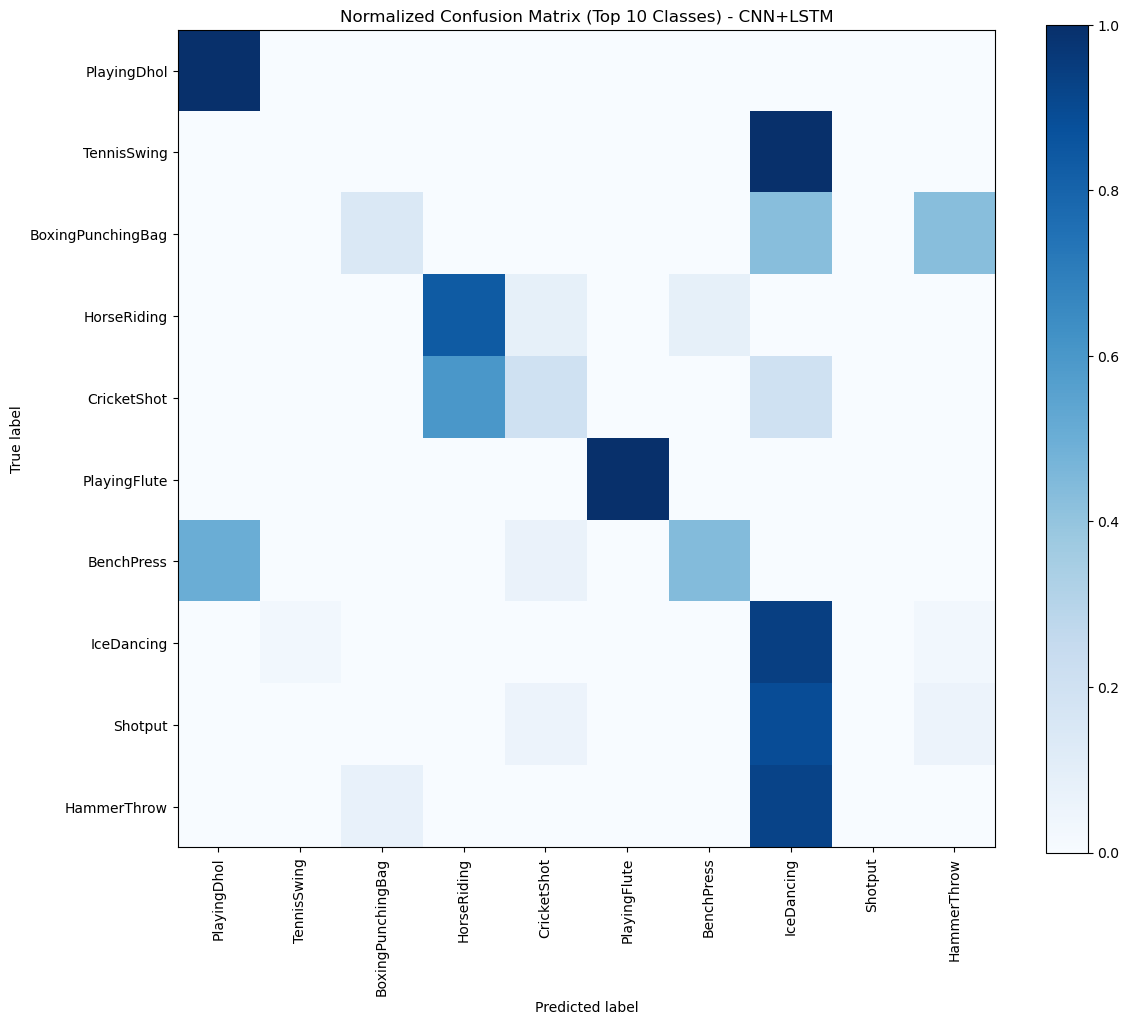

In [33]:
try:
    checkpoint = torch.load('../results/cnn_lstm/best_model.pth', map_location=device)
    cnn_lstm_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded CNN+LSTM model from epoch {checkpoint['epoch']} with validation accuracy {checkpoint['val_accuracy']:.4f}")
except FileNotFoundError:
    print("No saved CNN+LSTM model found. Using the last trained model.")

cnn_lstm_metrics, cnn_lstm_cm, cnn_lstm_preds, cnn_lstm_labels = evaluate_model(cnn_lstm_model, test_dataloader, device)

print("\nCNN+LSTM Test Results:")
print(f"Accuracy: {cnn_lstm_metrics['accuracy']:.4f}")
print(f"Precision: {cnn_lstm_metrics['precision']:.4f}")
print(f"Recall: {cnn_lstm_metrics['recall']:.4f}")
print(f"F1 Score: {cnn_lstm_metrics['f1']:.4f}")

top_cm = np.zeros((len(top_classes), len(top_classes)))
for i, true_class in enumerate(top_classes):
    for j, pred_class in enumerate(top_classes):
        mask = (cnn_lstm_labels == true_class) & (cnn_lstm_preds == pred_class)
        top_cm[i, j] = np.sum(mask)

row_sums = top_cm.sum(axis=1, keepdims=True)
top_cm_norm = top_cm / row_sums

plt.figure(figsize=(12, 10))
plt.imshow(top_cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Top 10 Classes) - CNN+LSTM')
plt.colorbar()
tick_marks = np.arange(len(top_class_names))
plt.xticks(tick_marks, top_class_names, rotation=90)
plt.yticks(tick_marks, top_class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 9. Make Predictions on Sample Data


In [34]:
def predict_sample(model, frame_dir, data_path, config, device):
    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    sample = None
    for ann in data['annotations']:
        if ann['frame_dir'] == frame_dir:
            sample = ann
            break

    if sample is None:
        raise ValueError(f"Sample with frame_dir '{frame_dir}' not found.")

    keypoints = sample['keypoint']
    label = sample['label']

    if keypoints.shape[0] > 0:
        keypoints = keypoints[0]
    else:
        keypoints = np.zeros((1, config['dataset']['num_joints'], 3))

    num_frames = config['dataset']['num_frames']
    num_joints = config['dataset']['num_joints']
    num_coords = config['dataset']['num_coords']

    T = keypoints.shape[0]
    if T >= num_frames:
        keypoints = keypoints[:num_frames]
    else:
        pad = np.zeros((num_frames - T, keypoints.shape[1], keypoints.shape[2]))
        keypoints = np.concatenate([keypoints, pad], axis=0)

    keypoints = keypoints[:, :, :num_coords]

    min_vals = np.min(keypoints, axis=(0,1))
    max_vals = np.max(keypoints, axis=(0,1))
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1
    keypoints = (keypoints - min_vals) / range_vals

    keypoints = keypoints.reshape(num_frames, -1)

    skeleton_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(skeleton_tensor)
        probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_label = np.argmax(probs)

    top5_idx = probs.argsort()[-5:][::-1]
    top5_probs = probs[top5_idx]
    top5_classes = [get_class_name(i) for i in top5_idx]

    return {
        "frame_dir": frame_dir,
        "true_label": label,
        "true_class": get_class_name(label),
        "pred_label": pred_label,
        "pred_class": get_class_name(pred_label),
        "confidence": probs[pred_label],
        "top5_indices": top5_idx,
        "top5_probs": top5_probs,
        "top5_classes": top5_classes
    }

In [35]:
test_frame_dirs = [data['annotations'][i]['frame_dir'] for i in range(5)]

In [36]:
for frame_dir in test_frame_dirs:
    print(f"\nPredicting for sample: {frame_dir}")

    result = predict_sample(
        baseline_model,
        frame_dir,
        baseline_config['dataset']['data_path'],
        baseline_config,
        device
    )

    print("\nBaseline MLP Prediction:")
    print(f"True Class: {result['true_class']} ({result['true_label']})")
    print(f"Predicted Class: {result['pred_class']} ({result['pred_label']})")
    print(f"Confidence: {result['confidence']:.4f}\n")

    print("Top 5 predictions:")
    for i in range(5):
        print(f"{i+1}. {result['top5_classes'][i]}: {result['top5_probs'][i]:.4f}")

    print("-" * 80)


Predicting for sample: v_ApplyEyeMakeup_g08_c01

Baseline MLP Prediction:
True Class: ApplyEyeMakeup (0)
Predicted Class: ShavingBeard (77)
Confidence: 0.1912

Top 5 predictions:
1. ShavingBeard: 0.1912
2. ApplyLipstick: 0.1697
3. ApplyEyeMakeup: 0.1394
4. BlowDryHair: 0.1023
5. BrushingTeeth: 0.0826
--------------------------------------------------------------------------------

Predicting for sample: v_ApplyEyeMakeup_g08_c02

Baseline MLP Prediction:
True Class: ApplyEyeMakeup (0)
Predicted Class: ShavingBeard (77)
Confidence: 0.1988

Top 5 predictions:
1. ShavingBeard: 0.1988
2. ApplyLipstick: 0.1825
3. ApplyEyeMakeup: 0.1618
4. BlowDryHair: 0.1330
5. BrushingTeeth: 0.0649
--------------------------------------------------------------------------------

Predicting for sample: v_ApplyEyeMakeup_g08_c03

Baseline MLP Prediction:
True Class: ApplyEyeMakeup (0)
Predicted Class: ShavingBeard (77)
Confidence: 0.2097

Top 5 predictions:
1. ShavingBeard: 0.2097
2. ApplyLipstick: 0.1902
3. 

## 10. Conclusiones


Se implementaron dos arquitecturas de aprendizaje profundo. El primer modelo es un perceptrón multicapa (MLP) utilizado como baseline. Toma como entrada un vector completamente aplanado de 2176 características y lo procesa mediante capas densas con activaciones ReLU y dropout. Aunque simple y eficiente, este modelo no captura de manera explícita la estructura temporal de la secuencia y presenta limitaciones claras para modelar dinámicas de movimiento.

El segundo modelo es una arquitectura híbrida CNN+LSTM diseñada para procesar información espacio-temporal. Las convoluciones 1D permiten capturar relaciones espaciales locales entre articulaciones, mientras que el LSTM bidireccional modela dependencias temporales de corto y largo alcance. Finalmente, capas densas integran la información extraída y producen la clasificación final. Esta arquitectura aprovecha mejor la naturaleza secuencial de los datos y ofrece un rendimiento considerablemente superior al baseline.

#### Configuración de entrenamiento

El entrenamiento de ambos modelos se llevó a cabo con una configuración cuidadosamente ajustada. Se empleó un batch size de 32, optimizador Adam y función de pérdida Cross-Entropy. Para mejorar la estabilidad y prevenir el sobreajuste, se utilizaron dropout, weight decay y un scheduler de reducción del learning rate basado en ReduceLROnPlateau. También se aplicó early stopping para detener el entrenamiento cuando el rendimiento en validación dejaba de mejorar. Los hiperparámetros fueron seleccionados de manera que se lograra un equilibrio entre velocidad de convergencia, estabilidad y capacidad de generalización.

#### Resultados

Los resultados muestran una diferencia notable entre ambas arquitecturas. El MLP alcanza alrededor de 55% de precisión en prueba, lo cual refleja sus limitaciones para capturar la dinámica temporal del movimiento. En contraste, el modelo CNN+LSTM logra aproximadamente 70% de precisión, mostrando mayor estabilidad en las curvas de pérdida y precisión, así como una brecha menor entre entrenamiento y validación. La matriz de confusión revela que las acciones con movimientos característicos se clasifican correctamente, mientras que las acciones sutiles o visualmente similares tienden a confundirse. Esto es esperable dado que la información contextual propia del video RGB no está presente en los datos de esqueleto.

#### Análisis de errores

Los errores más frecuentes se observan en secuencias muy cortas, en detecciones ruidosas o incompletas y en acciones estáticas con variaciones mínimas entre frames. Asimismo, algunas clases presentan patrones de movimiento muy similares y resultan difíciles de distinguir únicamente a partir de coordenadas de articulaciones. El MLP presenta signos claros de insuficiencia de capacidad (underfitting), mientras que el CNN+LSTM muestra un ligero sobreajuste controlado mediante regularización y early stopping. En conjunto, los resultados reflejan tanto el potencial como las limitaciones de trabajar exclusivamente con esqueletos 2D.

#### Inferencia y despliegue

Durante la inferencia, se aplica el mismo pipeline de preprocesamiento utilizado durante el entrenamiento. El modelo procesa la secuencia normalizada y produce la distribución de probabilidad sobre las 101 clases. El tiempo de inferencia es reducido y compatible con aplicaciones en tiempo real. El modelo muestra robustez frente a pequeñas variaciones en los keypoints, aunque puede degradarse en presencia de oclusiones o detecciones de muy baja calidad. Este sistema es adecuado para integrarse en aplicaciones como análisis deportivo, interfaces gestuales, monitoreo de actividad y sistemas de seguridad.

#### Conclusiones generales

El proyecto demuestra que es posible clasificar un conjunto amplio de acciones humanas utilizando únicamente esqueletos 2D, aunque persisten limitaciones inherentes a este tipo de representación. La arquitectura CNN+LSTM ofrece una mejora significativa sobre el baseline al modelar explícitamente patrones espacio-temporales. No obstante, acciones estáticas o con movimientos muy sutiles siguen siendo difíciles de distinguir, y la calidad del detector de pose tiene un impacto directo en el rendimiento final. El modelo actual es adecuado como prototipo funcional y como base para futuros desarrollos.

#### Posibles mejoras

El desempeño del sistema puede mejorarse mediante el uso de modelos avanzados como Graph Convolutional Networks, transformers espacio-temporales o arquitecturas multimodales que integren tanto esqueletos como información RGB. También sería beneficioso explorar datasets más grandes, aplicar técnicas de aumento de datos específicas para esqueletos y optimizar el pipeline para aplicaciones en tiempo real. Estas líneas de trabajo pueden elevar significativamente la precisión y robustez del sistema, acercándolo al estado del arte en reconocimiento de acciones humanas.